## Clustering using Kmodes

#### Find teammates by using clustering way
1. Kmodes is a clustering method focus on categorical data.
2. Though we are trying to input categorical data, we still need to make sure that categorical numbers are kept in a certain range. Otherwise, the alogoritms may fall into extremely slow.
3. The estimation is conducted by comparing cost value between variant number of clusters, the optimal point should see decreasing rate of cost started to slow.
4. The results shows that 5 clusters is optimal.
5. To improve team's background, I give other groups a small probability to be selected.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [2]:
from kmodes.kmodes import KModes
RANDOM =42


#### Reference
1. https://github.com/nicodv/kmodes/blob/master/kmodes/kmodes.py
2. https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering/comments

## Load Data

In [3]:
app_df = pd.read_csv('https://drive.google.com/uc?id=1mPK8_AasPMdqy3D9D0kxjjKcIXmhhcQo').set_index('userid')
bc_df = pd.read_csv('https://drive.google.com/uc?id=1sovKLesEqPbkUte_ysRP9mGQ1gFCO2ME').set_index('userid')

## Check dataset

In [4]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1250 entries, 95030aef3e970680d882f1527f549d9e to 808dc4e3f1546a46cdd135b000ced0dd
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   school                   1250 non-null   object
 1   other_school             109 non-null    object
 2   majors                   1250 non-null   object
 3   minors                   1250 non-null   object
 4   age_bin                  1250 non-null   object
 5   classification           1250 non-null   object
 6   first_generation         1250 non-null   bool  
 7   datascience_experience   1250 non-null   int64 
 8   technology_experience    1250 non-null   object
 9   num_hackathons_attended  1250 non-null   object
 10  workshop_suggestions     410 non-null    object
 11  relavent_industries      1250 non-null   object
dtypes: bool(1), int64(1), object(10)
memory usage: 118.4+ KB


## Data clean

* some columns are objects that contain with bracket like major, minor, first we use eval() to let python treat than as list and than use pop() and explode() to extract infos inside the list.

* A key to use k-modes is to limit the number of categories, so for those with huge category numbers, we may have to trim down to a small amount.

* Finally transform data into one-hot-labeled format


In [13]:

app_df['major_with_minor'] = app_df['majors'].apply(eval)+app_df['minors'].apply(eval)

#df1 = app_df['major_with_minor'].explode()
df1 = app_df.pop('major_with_minor').explode()
majors_df = pd.crosstab(df1.index, df1)



bc = pd.crosstab(bc_df.index,bc_df.workshop)

df3 = app_df.pop('technology_experience').apply(eval).explode()
tech_df = pd.crosstab(df3.index,df3)

df4 = app_df.pop('relavent_industries').apply(eval).explode()
ind_df = pd.crosstab(df4.index,df4)

lst = app_df['school'].value_counts()[:10].index.tolist()

app_df['school'] = pd.Categorical(app_df['school'].values.tolist(),categories=lst)
app_df['school'].fillna('Other',inplace =True)

app_df['A&M_student'] = (app_df['school'] =='Texas A&M University').replace({True:1,False:0}).astype('category')

app_df['with_suggestion'] = (app_df['workshop_suggestions'].notna()).replace({True:1,False:0}).astype('category')

#app_df['first_generation'] = app_df['first_generation'].replace{{True:1,False:0}}

app_df['num_hackathons_attended'] = app_df['num_hackathons_attended'].astype('category')

app_df['datascience_experience'] =app_df['datascience_experience'].astype('category')

app_df['first_generation'] =app_df['first_generation'].astype('category')

# data clean
#app_df.drop(columns=['workshop_suggestions','other_school','majors','minors','first_generation'],inplace=True)
app_df.drop(columns=['school','workshop_suggestions','other_school','majors','minors','first_generation'],inplace=True)

#app_df.info()

app_df = pd.get_dummies(app_df,drop_first=True,dummy_na=True)

app_df = app_df.join(majors_df)
app_df = app_df.join(bc)
app_df = app_df.join(tech_df)
app_df = app_df.join(ind_df)

In [14]:
app_df.head()

,"age_bin_(18, 20]","age_bin_(20, 22]","age_bin_(22, 25]","age_bin_(25, 30]","age_bin_(30, 50]",age_bin_nan,classification_Jr,classification_Ma,classification_O,classification_PhD,...,energy,finance,healthcare,insurance,other,public_policy,retail,sports,technology,transportation
userid,,,,,,,,,,,,,,,,,,,,,
95030aef3e970680d882f1527f549d9e,0,0,0,1,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
68ad76832a913de0d62df103b3d5b807,1,0,0,0,0,0,1,0,0,0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
959d8992667c8bfc1ac665f234360eb6,0,0,1,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
76b067cd5f3e1b1976d2e2eeceedf567,1,0,0,0,0,0,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
f44cfb96520a82e172ce2ae116b21187,0,0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clustering

In [15]:
# fill null value 
app_df.fillna(0,inplace=True)

In [16]:
x = app_df.to_numpy()
y = app_df.index.to_numpy()

In [17]:
cost = []
for num_clusters in list(range(2,11)):
    kmode = KModes(n_clusters=num_clusters, init='Cao', n_init=1, verbose=0,random_state=RANDOM)
    kmode.fit_predict(x)
    cost.append(kmode.cost_)

Text(0, 0.5, 'cost')

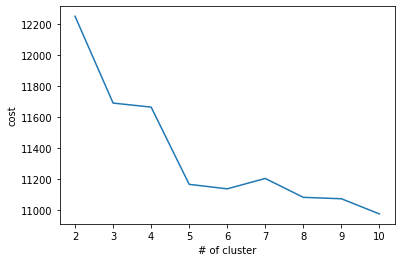

In [18]:
sns.lineplot(y=cost,x =range(2,11,1))
plt.xlabel('# of cluster')
plt.ylabel('cost')

In [19]:
kmode = KModes(n_clusters=5, init='Cao', n_init=1, verbose=0,random_state=RANDOM)
cluster = kmode.fit_predict(x)

In [20]:
pd.Series(cluster).value_counts()

0    710
3    195
4    164
2     94
1     87
dtype: int64

In [820]:
with open('kmode.pkl','wb') as f:
    pickle.dump(kmode,f)

In [821]:
# save centriod of modes
km_h_df = pd.DataFrame(kmode.cluster_centroids_,columns=app_df.columns)
km_h_df

,"age_bin_(18, 20]","age_bin_(20, 22]","age_bin_(22, 25]","age_bin_(25, 30]","age_bin_(30, 50]",age_bin_nan,classification_Jr,classification_Ma,classification_O,classification_PhD,...,energy,finance,healthcare,insurance,other,public_policy,retail,sports,technology,transportation
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check each cluster

* First Cluster
    - The first cluster including the students that are mostly from TAMU CS major.
* Second Cluster
    - The second cluster including the students that are more highly focus on __ML and DL python libraries__.
* Third Cluster
    - The Third cluster including the __TAMU__ students that are more highly focus on ML and DL techniques.
* Fourth Cluster
    - The Fourth cluster including  __CS students that are  not from TAMU__.
* Fifth Cluster
    - The Fifth cluster including TAMU students that are not CS major but familiar with data processing packages.

In [26]:
app_df['cluster']=cluster

In [45]:
app_df.loc[app_df['cluster']==0,].sum(axis=0).sort_values(ascending =False).head(10)

A&M_student_1.0                   477.0
Python                            467.0
Computer Science & Engineering    415.0
Excel                             359.0
technology                        357.0
datascience_experience_1.0        286.0
age_bin_(18, 20]                  254.0
datascience_experience_2.0        199.0
num_hackathons_attended_1-3       191.0
with_suggestion_1.0               175.0
dtype: float64

* First Cluster
    - The first cluster including the students that are mostly from TAMU CS major or technology background.

In [47]:
app_df[app_df['cluster']==1].iloc[:,:-1].sum(axis=0).sort_values(ascending =False).head(10)

Python          86.0
NumPy           83.0
Pandas          81.0
Scikit-learn    80.0
TensorFlow      76.0
Keras           69.0
technology      68.0
cloud           68.0
SQL             66.0
R               58.0
dtype: float64

* Second Cluster
    - The second cluster including the students that are more highly focus on __ML and DL python libraries__.

In [48]:
app_df[app_df['cluster']==2].iloc[:,:-1].sum(axis=0).sort_values(ascending =False).head(10)

Python                        94.0
NumPy                         90.0
Pandas                        88.0
Scikit-learn                  88.0
datascience_experience_2.0    77.0
TensorFlow                    73.0
Keras                         71.0
technology                    71.0
A&M_student_1.0               66.0
MATLAB                        61.0
dtype: float64

* Third Cluster
    - The Third cluster including the __TAMU__ students that are more highly focus on ML and DL techniques.

In [49]:
app_df[app_df['cluster']==3].iloc[:,:-1].sum(axis=0).sort_values(ascending =False).head(10)

Python                            190.0
age_bin_(18, 20]                  159.0
NumPy                             157.0
Computer Science & Engineering    155.0
technology                        146.0
Pandas                            136.0
num_hackathons_attended_1-3       132.0
classification_Jr                 124.0
Excel                             124.0
datascience_experience_2.0        118.0
dtype: float64

* Fourth Cluster
    - The Fourth cluster including  __CS students that are  not from TAMU__.

In [51]:
app_df[app_df['cluster']==4].iloc[:,:-1].sum(axis=0).sort_values(ascending =False).head(10)

Python                        152.0
Pandas                        134.0
NumPy                         129.0
datascience_experience_2.0    122.0
SQL                           119.0
classification_Ma             115.0
A&M_student_1.0               114.0
R                             113.0
Excel                         103.0
Scikit-learn                  101.0
dtype: float64

* Fifth Cluster
    - The Fifth cluster including TAMU students that are not CS major but familiar with data processing packages.

## Wrap-up

In [823]:
 def team_mate_suggestion(user_id, num =3):
        team_mate=[]
        p=[0.05,0.05,0.05,0.05,0.05]
        cluster_id = app_df.loc[user_id]['cluster']
        p[int(cluster_id)]=0.8 # probability of chosing in this group
        cluster_ids =[0.0,1.,2.,3.,4.]
        cluster_arr = np.random.choice(cluster_ids,num,p=p)
        for i in cluster_arr:
            team_mate.append(app_df.groupby('cluster').get_group(cluster_ids[int(i)]).sample(1).index.tolist())
        return list(np.squeeze(team_mate))

In [824]:
# Demo random pick one people and see the suggestion
ppl = app_df.sample(1).index.tolist()[0]
app_df.loc[team_mate_suggestion(ppl),]

,"age_bin_(18, 20]","age_bin_(20, 22]","age_bin_(22, 25]","age_bin_(25, 30]","age_bin_(30, 50]",age_bin_nan,classification_Jr,classification_Ma,classification_O,classification_PhD,...,finance,healthcare,insurance,other,public_policy,retail,sports,technology,transportation,cluster
userid,,,,,,,,,,,,,,,,,,,,,
ff18a465594abe4602cf94d8ba03f8bc,0,0,0,1,0,0,0,1,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1746fa5a434f37b09db3fa7a40e4eaa7,0,0,1,0,0,0,0,0,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
10c2ed25110849a368c8ae7cf52cee63,0,0,0,1,0,0,0,0,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
